# ESAM Online DINO 对齐诊断（RGB一致性 + 注入命中率）

本 notebook 用来验证两件事：

1. **投影是否真的对齐像素**：用 *RGB 一致性*（点云颜色 vs 投影像素颜色）做强证据检查。
2. **DINO 是否真的注入到 Minkowski/decoder 坐标系**：用 *hit-rate*（features_at_coordinates 命中率）检验是否存在 elastic/量化/stride 坐标失配。

> 说明：`valid_rate` 只能证明 uv 在图像范围内，并不能证明采样到正确像素，更不能证明 DINO 特征真的被网络拿到。


In [9]:
# 显式将工作目录和 sys.path 切换到本地 3D_Reconstruction 根目录，
# 确保优先使用本仓库的 oneformer3d 而不是可能安装在 site-packages 里的版本。
import os
import sys
repo_root = '/home/nebula/xxy/3D_Reconstruction'
os.chdir(repo_root)
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
print('CWD =', os.getcwd())
print('sys.path[0] =', sys.path[0])

CWD = /home/nebula/xxy/3D_Reconstruction
sys.path[0] = /home/nebula/xxy/3D_Reconstruction


In [10]:
# 0. 环境与基础导入（请在 ESAM conda 环境运行）
import os
import sys
from copy import deepcopy
from pathlib import Path

import numpy as np
import torch

import matplotlib.pyplot as plt

# --- IMPORTANT ---
# 必须在 import oneformer3d / Config.fromfile 之前，把仓库根目录放到 sys.path[0]，
# 否则可能会误用 site-packages 里的旧版本 oneformer3d，导致你看到的修复不生效。
ROOT = Path('/home/nebula/xxy/3D_Reconstruction')
os.chdir(str(ROOT))
root_str = str(ROOT)
# 去重后强制插到最前
sys.path = [p for p in sys.path if p != root_str]
sys.path.insert(0, root_str)

from mmengine.config import Config
from mmengine.dataset import DefaultSampler, default_collate
from torch.utils.data import DataLoader

from mmdet3d.registry import MODELS, DATASETS

import MinkowskiEngine as ME

# ESAM/OneFormer3D 代码（务必在 sys.path 修正后再 import）
from oneformer3d.img_backbone import apply_3d_transformation
from oneformer3d.projection_utils import project_points_to_uv, sample_img_feat
import oneformer3d.mixformer3d as mixformer3d_mod

print('CWD =', os.getcwd())
print('sys.path[0] =', sys.path[0])
print('oneformer3d.mixformer3d file =', mixformer3d_mod.__file__)
print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device



CWD = /home/nebula/xxy/3D_Reconstruction
sys.path[0] = /home/nebula/xxy/3D_Reconstruction
oneformer3d.mixformer3d file = /home/nebula/xxy/3D_Reconstruction/oneformer3d/mixformer3d.py
torch: 1.13.1
cuda available: True


'cuda'

In [11]:
# 1. 选择配置（可切换）
# - 在线 DINO + class-aware: configs/ESAM/ESAM_sv_scannet200_dino_cls.py
# - 在线 DINO + class-agnostic: configs/ESAM_CA/ESAM_sv_scannet200_CA_dino.py
cfg_path = 'configs/ESAM/ESAM_sv_scannet200_dino_cls.py'
cfg = Config.fromfile(cfg_path)
print('Loaded cfg:', cfg_path)
print('train ann:', cfg.train_dataloader.dataset.ann_file)
print('val ann:', cfg.val_dataloader.dataset.ann_file)
print('train batch_size:', cfg.train_dataloader.batch_size)


Loaded cfg: configs/ESAM/ESAM_sv_scannet200_dino_cls.py
train ann: scannet200_sv_oneformer3d_infos_train_dino.pkl
val ann: scannet200_sv_oneformer3d_infos_val_dino.pkl
train batch_size: 16


In [12]:
# 2. 构建一个用于诊断的 dataset pipeline（默认：关闭 ColorJitter，保留几何增强 + ResizeForDINO + flip 同步）
# 说明：RGB一致性检查需要“无颜色扰动”的图像；否则点色 vs 像素色天然不一致。

def build_debug_cfg(base_cfg: Config, *, elastic_p=None, remove_color_jitter=True, remove_points_norm=False):
    cfg2 = deepcopy(base_cfg)
    pipe = deepcopy(cfg2.train_dataloader.dataset.pipeline)

    new_pipe = []
    for t in pipe:
        if not isinstance(t, dict) or 'type' not in t:
            new_pipe.append(t)
            continue
        if remove_color_jitter and t['type'] == 'ColorJitterImg':
            continue
        if remove_points_norm and t['type'] == 'NormalizePointsColor_':
            continue
        if elastic_p is not None and t['type'] == 'ElasticTransfrom':
            t = deepcopy(t)
            t['p'] = float(elastic_p)
        new_pipe.append(t)

    cfg2.train_dataloader.dataset.pipeline = new_pipe
    return cfg2

# 诊断配置：
# - RGB一致性：建议 remove_color_jitter=True，remove_points_norm=True（保留原始点色0-255）
# - hit-rate 对比：建议 elastic_p=0.0 vs 0.5 分别跑一遍
cfg_dbg_rgb = build_debug_cfg(cfg, elastic_p=0.0, remove_color_jitter=True, remove_points_norm=True)
cfg_dbg_hit_el0 = build_debug_cfg(cfg, elastic_p=0.0, remove_color_jitter=False, remove_points_norm=False)
cfg_dbg_hit_el05 = build_debug_cfg(cfg, elastic_p=0.5, remove_color_jitter=False, remove_points_norm=False)

print('rgb debug: ', [t['type'] for t in cfg_dbg_rgb.train_dataloader.dataset.pipeline if isinstance(t, dict)])
print('hit debug (el=0): ', [t['type'] for t in cfg_dbg_hit_el0.train_dataloader.dataset.pipeline if isinstance(t, dict) and t['type']=='ElasticTransfrom'])
print('hit debug (el=0.5): ', [t['type'] for t in cfg_dbg_hit_el05.train_dataloader.dataset.pipeline if isinstance(t, dict) and t['type']=='ElasticTransfrom'])


rgb debug:  ['LoadPointsFromFile', 'LoadAnnotations3D_', 'SwapChairAndFloor', 'PointSegClassMapping', 'LoadSingleImageFromFile', 'BGR2RGBImg', 'RandomFlip3D', 'GlobalRotScaleTrans', 'ResizeForDINO', 'AddSuperPointAnnotations', 'ElasticTransfrom', 'Pack3DDetInputs_']
hit debug (el=0):  ['ElasticTransfrom']
hit debug (el=0.5):  ['ElasticTransfrom']


In [13]:
# 3. 构建 dataset + dataloader（batch=1，便于debug）
def build_loader(cfg_obj: Config, *, batch_size=1, num_workers=0, shuffle=False):
    dataset = DATASETS.build(cfg_obj.train_dataloader.dataset)
    sampler = DefaultSampler(dataset, shuffle=shuffle)
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=sampler,
        collate_fn=default_collate,
        num_workers=num_workers,
    )
    return dataset, loader

ds_rgb, dl_rgb = build_loader(cfg_dbg_rgb, batch_size=1)
batch_rgb = next(iter(dl_rgb))
print('batch keys:', batch_rgb.keys())
print('inputs keys:', batch_rgb['inputs'].keys())
print('has img:', 'img' in batch_rgb['inputs'])
print('has cam_info:', 'cam_info' in batch_rgb['inputs'])
print('points type:', type(batch_rgb['inputs']['points']))
print('len points:', len(batch_rgb['inputs']['points']))
print('first points shape:', batch_rgb['inputs']['points'][0].shape)
print('cam_info type:', type(batch_rgb['inputs'].get('cam_info', None)))


[LoadCamInfo] 使用固定标准内参: [577.870605, 577.870605, 319.5, 239.5] (ScanNet官方策略)
[Pack3DDetInputs_] keys=['points', 'gt_labels_3d', 'pts_semantic_mask', 'pts_instance_mask', 'sp_pts_mask', 'gt_sp_masks', 'elastic_coords', 'img', 'cam_info'], inputs_keys=['points', 'elastic_coords', 'img', 'cam_info']
batch keys: dict_keys(['data_samples', 'inputs'])
inputs keys: dict_keys(['points', 'elastic_coords', 'img', 'cam_info'])
has img: True
has cam_info: True
points type: <class 'torch.Tensor'>
len points: 1
first points shape: torch.Size([20000, 6])
cam_info type: <class 'list'>


In [14]:
# 4. 打印本样本的几何meta快照（debug必备）
ds = batch_rgb['data_samples'][0]
img_meta = getattr(ds, 'img_metas', None) or {}
print('transformation_3d_flow:', img_meta.get('transformation_3d_flow'))
print('pcd_horizontal_flip:', img_meta.get('pcd_horizontal_flip'))
print('pcd_vertical_flip:', img_meta.get('pcd_vertical_flip'))
print('pcd_scale_factor:', img_meta.get('pcd_scale_factor'))
print('pcd_trans:', img_meta.get('pcd_trans'))
print('pcd_rotation exists:', 'pcd_rotation' in img_meta)
print('img_flip:', img_meta.get('img_flip', img_meta.get('flip', False)))

cam_info = batch_rgb['inputs']['cam_info'][0] if isinstance(batch_rgb['inputs']['cam_info'], list) else batch_rgb['inputs']['cam_info']
# cam_info 在 Pack 后通常是 list[dict]，单帧我们取第一个 dict
if isinstance(cam_info, list):
    cam0 = cam_info[0]
else:
    cam0 = cam_info
print('cam_info keys:', cam0.keys())
print('intrinsics:', cam0.get('intrinsics'))
print('img_size_dino:', cam0.get('img_size_dino'))
pose = cam0.get('pose', cam0.get('extrinsics'))
print('pose/extrinsics type:', type(pose), 'shape:', getattr(pose, 'shape', None))


transformation_3d_flow: ['HF', 'R', 'S', 'T']
pcd_horizontal_flip: True
pcd_vertical_flip: False
pcd_scale_factor: 1.0973966515326619
pcd_trans: [    0.11624   -0.072965    -0.07829]
pcd_rotation exists: True
img_flip: True
cam_info keys: dict_keys(['intrinsics', 'extrinsics', 'pose', 'img_size_dino'])
intrinsics: [tensor([505.6368], dtype=torch.float64), tensor([505.6368], dtype=torch.float64), tensor([279.5625], dtype=torch.float64), tensor([209.5625], dtype=torch.float64)]
img_size_dino: [tensor([420]), tensor([560])]
pose/extrinsics type: <class 'torch.Tensor'> shape: torch.Size([1, 4, 4])


## 5) RGB一致性检查（强证据）
步骤：
- 用 `apply_3d_transformation(reverse=True)` 将训练坐标反解回 world
- world→camera（pose/extrinsics 为 cam2world，取逆）
- 用更新后的 intrinsics + img_size_dino（420×560）投影到像素坐标
- 若 `img_flip=True`，对 u 做镜像
- 在图像上采样像素颜色，与点云颜色对比


In [15]:
# 5.1 取输入（RGB一致性版本：无ColorJitter、无点色Normalize）
pts = batch_rgb['inputs']['points'][0]  # (N,6) xyzrgb
img = batch_rgb['inputs']['img'][0] if isinstance(batch_rgb['inputs']['img'], list) else batch_rgb['inputs']['img']
if isinstance(img, torch.Tensor):
    # 期望 (C,H,W)
    if img.dim() == 4:
        img = img[0]
    if img.shape[0] not in (1,3):
        # 可能是 (H,W,C)
        img = img.permute(2,0,1).contiguous()
else:
    img = torch.tensor(img)
    if img.dim() == 3 and img.shape[-1] in (1,3):
        img = img.permute(2,0,1).contiguous()
img = img.float()

xyz_train = pts[:, :3].float()
rgb_pts = pts[:, 3:6].float()  # 期望 0..255

# 5.2 反解 3D 增强（train -> world）
xyz_world = torch.as_tensor(
    apply_3d_transformation(xyz_train.clone(), coord_type='DEPTH', img_meta=img_meta, reverse=True),
    dtype=torch.float32
)

# 5.3 world -> camera
pose = cam0.get('pose', cam0.get('extrinsics', None))
if pose is None:
    raise RuntimeError('cam_info has no pose/extrinsics')

# pose 通常是 cam2world 4x4；但在 batch/collate 后可能出现 (1,4,4) 或 (1,1,4,4)
T_c2w = torch.as_tensor(pose, dtype=torch.float32)
if T_c2w.shape[-2:] != (4, 4):
    raise RuntimeError(f'Unexpected cam2world shape: {tuple(T_c2w.shape)}')
if T_c2w.dim() > 2:
    # 压平所有前导维度，单帧取第一个
    T_c2w = T_c2w.reshape(-1, 4, 4)[0]

T_w2c = torch.linalg.inv(T_c2w)
# 确保所有张量在同一 device（points/img_meta 可能在 GPU 上）
dev = xyz_world.device
T_w2c = T_w2c.to(device=dev)
xyz_h = torch.cat([
    xyz_world,
    torch.ones((xyz_world.shape[0], 1), dtype=torch.float32, device=dev)
], dim=1)
xyz_cam = (xyz_h @ T_w2c.transpose(0, 1))[:, :3]
# 5.4 投影到 420x560 像素坐标
H_img, W_img = cam0.get('img_size_dino', (img.shape[-2], img.shape[-1]))
fx, fy, cx, cy = cam0['intrinsics']
uv, valid = project_points_to_uv(
    xyz_cam, feat_hw=(int(H_img), int(W_img)),
    max_depth=float(cam0.get('max_depth', 20.0)),
    standard_intrinsics=(float(fx), float(fy), float(cx), float(cy)),
    already_scaled=True,
)

# 5.5 若 image 已被 pipeline flip，则对 u 镜像（与模型内逻辑一致）
if bool(img_meta.get('img_flip', img_meta.get('flip', False))):
    uv = uv.clone()
    uv[:, 0] = float(W_img - 1) - uv[:, 0]

print('img shape:', tuple(img.shape), 'H_img,W_img:', (H_img,W_img))
print('valid_rate:', float(valid.float().mean().item()))


img shape: (3, 420, 560) H_img,W_img: (tensor([420]), tensor([560]))
valid_rate: 1.0


valid_rate=1.0000, n_valid=20000/20000
RGB abs error (valid points):
  mean: [1.6707383394241333, 1.60239839553833, 1.6573566198349] overall: 1.6434978246688843
  median overall: 0.8333223462104797
  pct < 10: 0.9832000136375427


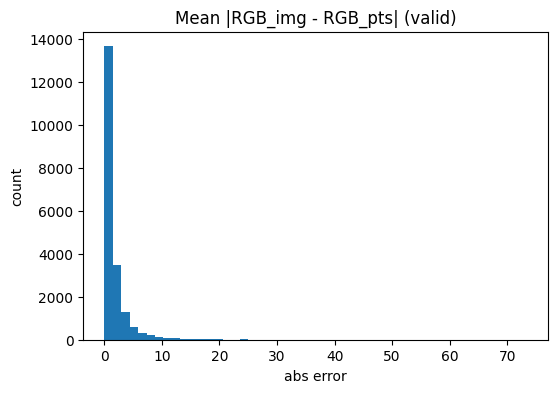

[Quick checks] (lower is better)
[nearest(BGR)] mean: [1.6707383394241333, 1.60239839553833, 1.6573566198349] overall: 1.6434978246688843 median overall: 0.8333223462104797 pct < 10: 0.9832000136375427
[nearest(RGB swap)] mean: [46.97045135498047, 1.60239839553833, 46.888755798339844] overall: 31.82053565979004 median overall: 29.479578018188477 pct < 10: 0.15105000138282776
[bilinear(BGR)] mean: [1.3116589784622192, 1.2830926179885864, 1.320862889289856] overall: 1.30520498752594 median overall: 0.6847991943359375 pct < 10: 0.990149974822998
[bilinear(RGB swap)] mean: [46.929874420166016, 1.2830926179885864, 46.89110565185547] overall: 31.701358795166016 median overall: 29.337722778320312 pct < 10: 0.15485000610351562


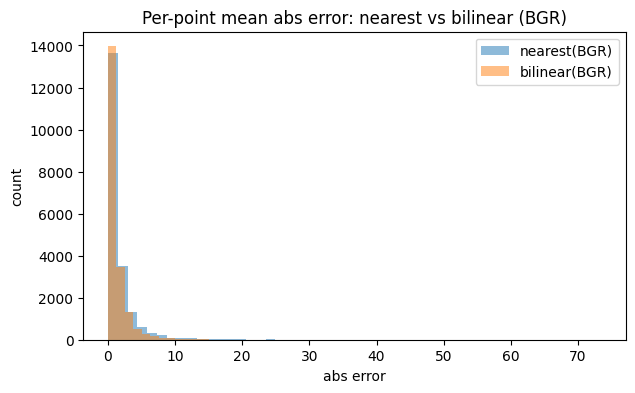

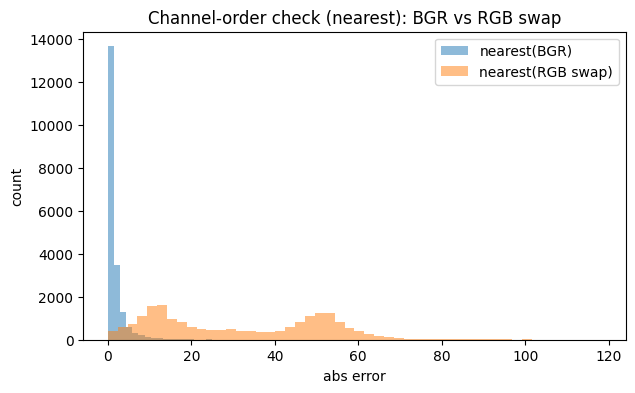

In [16]:
# 5.6 在图像上采样像素颜色，并与点色对比（鲁棒版：处理无valid点/NaN）
# 使用最近邻：round 后 clamp
u = uv[:, 0]
v = uv[:, 1]
u_i = torch.round(u).long().clamp(0, int(W_img)-1)
v_i = torch.round(v).long().clamp(0, int(H_img)-1)

# img: (3,H,W) in 0..255 (mmcv读取通常是uint8->float)
rgb_img = img[:3, v_i, u_i].t()  # (N,3)

# 额外过滤：finite + valid
mask = valid.bool()
mask = mask & torch.isfinite(rgb_img).all(dim=1) & torch.isfinite(rgb_pts).all(dim=1)

n_valid = int(mask.sum().item())
valid_rate = float(valid.float().mean().item()) if torch.is_tensor(valid) else float('nan')
print(f'valid_rate={valid_rate:.4f}, n_valid={n_valid}/{int(valid.numel())}')

if n_valid == 0:
    # 诊断：到底是深度不合法、uv越界、还是数值NaN
    z = xyz_cam[:, 2]
    max_depth = float(cam0.get('max_depth', 20.0))
    depth_ok = ((z > 0.3) & (z < max_depth) & torch.isfinite(z)).float().mean().item()
    uv_finite = torch.isfinite(uv).all(dim=1).float().mean().item()
    print('No valid points for RGB consistency check.')
    print(f'  depth_ok_ratio (0.3<z<{max_depth}): {depth_ok:.4f}')
    print(f'  uv_finite_ratio: {uv_finite:.4f}')
    print('  xyz_cam stats:',
          'z_min=', float(z[torch.isfinite(z)].min().item()) if torch.isfinite(z).any() else None,
          'z_max=', float(z[torch.isfinite(z)].max().item()) if torch.isfinite(z).any() else None)
    # uv 范围（不论 valid 与否）
    u0 = uv[:, 0]
    v0 = uv[:, 1]
    u0f = u0[torch.isfinite(u0)]
    v0f = v0[torch.isfinite(v0)]
    if u0f.numel() > 0 and v0f.numel() > 0:
        print(f'  uv_range_all: u=[{float(u0f.min().item()):.1f},{float(u0f.max().item()):.1f}] '
              f'v=[{float(v0f.min().item()):.1f},{float(v0f.max().item()):.1f}]')
    else:
        print('  uv_range_all: None (non-finite)')
else:
    diff = (rgb_img - rgb_pts).abs()
    diff_valid = diff[mask]

    print('RGB abs error (valid points):')
    print('  mean:', diff_valid.mean(dim=0).tolist(), 'overall:', float(diff_valid.mean().item()))
    print('  median overall:', float(diff_valid.mean(dim=1).median().item()))
    print('  pct < 10:', float((diff_valid.mean(dim=1) < 10).float().mean().item()))

    plt.figure(figsize=(6,4))
    plt.hist(diff_valid.mean(dim=1).detach().cpu().numpy(), bins=50)
    plt.title('Mean |RGB_img - RGB_pts| (valid)')
    plt.xlabel('abs error')
    plt.ylabel('count')
    plt.show()


    # --- Quick checks ---
    # (1) Bilinear sampling (sub-pixel) to test edge/rounding sensitivity.
    # (2) BGR vs RGB swap to test channel-order mismatch (mmcv often loads BGR).
    import torch.nn.functional as F

    H_img_i = int(H_img)
    W_img_i = int(W_img)

    def _sample_img_bilinear(img_chw: torch.Tensor, uv_pix: torch.Tensor, H: int, W: int, *, align_corners: bool = False) -> torch.Tensor:
        img4 = img_chw[:3].unsqueeze(0)  # (1,3,H,W)
        u_ = uv_pix[:, 0]
        v_ = uv_pix[:, 1]
        if align_corners:
            x = 2.0 * u_ / max(float(W - 1), 1.0) - 1.0
            y = 2.0 * v_ / max(float(H - 1), 1.0) - 1.0
        else:
            x = 2.0 * (u_ + 0.5) / float(W) - 1.0
            y = 2.0 * (v_ + 0.5) / float(H) - 1.0
        grid = torch.stack([x, y], dim=-1).view(1, -1, 1, 2)  # (1,N,1,2)
        samp = F.grid_sample(img4, grid, mode='bilinear', padding_mode='border', align_corners=align_corners)
        return samp.squeeze(0).squeeze(-1).permute(1, 0)  # (N,3)

    img_bgr = img[:3]
    img_rgb = img_bgr[[2, 1, 0]]

    rgb_nearest_bgr = rgb_img
    rgb_nearest_rgb = img_rgb[:, v_i, u_i].t()

    rgb_bilinear_bgr = _sample_img_bilinear(img_bgr, uv, H_img_i, W_img_i, align_corners=False)
    rgb_bilinear_rgb = _sample_img_bilinear(img_rgb, uv, H_img_i, W_img_i, align_corners=False)

    def _per_point_mean_abs(rgb_img_x: torch.Tensor) -> torch.Tensor:
        d = (rgb_img_x - rgb_pts).abs()
        dv = d[mask]
        return dv.mean(dim=1)

    def _print_err(name: str, rgb_img_x: torch.Tensor) -> torch.Tensor:
        d = (rgb_img_x - rgb_pts).abs()
        dv = d[mask]
        per = dv.mean(dim=1)
        print(f'[{name}] mean:', dv.mean(dim=0).tolist(),
              'overall:', float(dv.mean().item()),
              'median overall:', float(per.median().item()),
              'pct < 10:', float((per < 10).float().mean().item()))
        return per

    print('[Quick checks] (lower is better)')
    e_near_bgr = _print_err('nearest(BGR)', rgb_nearest_bgr)
    e_near_rgb = _print_err('nearest(RGB swap)', rgb_nearest_rgb)
    e_bi_bgr = _print_err('bilinear(BGR)', rgb_bilinear_bgr)
    e_bi_rgb = _print_err('bilinear(RGB swap)', rgb_bilinear_rgb)

    plt.figure(figsize=(7, 4))
    plt.hist(e_near_bgr.detach().cpu().numpy(), bins=50, alpha=0.5, label='nearest(BGR)')
    plt.hist(e_bi_bgr.detach().cpu().numpy(), bins=50, alpha=0.5, label='bilinear(BGR)')
    plt.legend()
    plt.title('Per-point mean abs error: nearest vs bilinear (BGR)')
    plt.xlabel('abs error')
    plt.ylabel('count')
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(e_near_bgr.detach().cpu().numpy(), bins=50, alpha=0.5, label='nearest(BGR)')
    plt.hist(e_near_rgb.detach().cpu().numpy(), bins=50, alpha=0.5, label='nearest(RGB swap)')
    plt.legend()
    plt.title('Channel-order check (nearest): BGR vs RGB swap')
    plt.xlabel('abs error')
    plt.ylabel('count')
    plt.show()


In [ ]:
# 5.6b Patch-grid RGB consistency
# 目标：直接在 token 网格 (30x40) 上做 RGB consistency，专门抓
# - valid_rate/hit_ratio 都高，但 token 坐标系存在半个 patch 偏移（例如 cx/cy 的 +0.5/-0.5 处理不一致）
#
# 做法：
# 1) 用 (420x560) 图像构造 patch-grid RGB 特征图：每个 14x14 patch 做 mean RGB -> (3,30,40)
# 2) 用与你模型一致的方式将 xyz_cam 投影到 patch 网格坐标 (u_feat,v_feat)
# 3) 在 patch-grid RGB 上用同样的采样方式（grid_sample/bilinear）取颜色，与点色比较

from oneformer3d.projection_utils import sample_img_feat

# 保证 patch_rgb_map / uv / rgb_pts 在同一 device
_dev = xyz_cam.device
if isinstance(img, torch.Tensor):
    img = img.to(_dev)
# img_best 可能来自 img 的切片
try:
    img_best = img_best.to(_dev)
except Exception:
    pass
try:
    rgb_pts_dev = rgb_pts.to(_dev)
except Exception:
    rgb_pts_dev = rgb_pts

P = 14
H_img_i, W_img_i = int(H_img), int(W_img)
H_feat, W_feat = H_img_i // P, W_img_i // P
assert (H_img_i % P == 0) and (W_img_i % P == 0), (H_img_i, W_img_i)

# 选择正确的颜色通道顺序（自动：哪个更接近点色就用哪个）
img_bgr = img[:3]
img_rgb = img_bgr[[2, 1, 0]]

try:
    err_bgr = (img_bgr[:, v_i, u_i].t() - rgb_pts_dev).abs()
    err_rgb = (img_rgb[:, v_i, u_i].t() - rgb_pts_dev).abs()
    mb = float(err_bgr[mask].mean().item()) if int(mask.sum()) > 0 else float('inf')
    mr = float(err_rgb[mask].mean().item()) if int(mask.sum()) > 0 else float('inf')
    img_best = img_bgr if mb <= mr else img_rgb
    print('[patch-grid] channel select:', ('BGR' if mb <= mr else 'RGB'), 'mean_abs=', min(mb, mr))
except Exception as e:
    img_best = img_bgr
    print('[patch-grid] channel select fallback to BGR, reason:', repr(e))

# 1) 构造 patch-grid RGB： (3,420,560) -> (1,3,30,40)
patch_rgb = img_best.reshape(3, H_feat, P, W_feat, P).mean(dim=(2, 4))
patch_rgb_map = patch_rgb.unsqueeze(0)  # (1,3,30,40)

# 2) 构造两套 patch 坐标：
#   - correct：cx/cy 都用 ( +0.5)*scale -0.5（与 grid_sample align_corners=False 的中心对齐）
#   - buggy_cy：cx 用 correct，但 cy 用旧的 cy*scale（常见“只修了cx没修cy”）
scale_w = float(W_feat) / float(W_img_i)
scale_h = float(H_feat) / float(H_img_i)
fx_img, fy_img, cx_img, cy_img = [float(x) for x in cam0['intrinsics']]
fx_feat = fx_img * scale_w
fy_feat = fy_img * scale_h
cx_feat = (cx_img + 0.5) * scale_w - 0.5
cy_feat = (cy_img + 0.5) * scale_h - 0.5
cy_feat_buggy = cy_img * scale_h

x, y, z = xyz_cam[:, 0], xyz_cam[:, 1], xyz_cam[:, 2]
valid_z = (z > 0.3) & (z < float(cam0.get('max_depth', 20.0))) & torch.isfinite(z)
ratio_ok = valid_z & (z.abs() > torch.finfo(z.dtype).eps)
rx = torch.zeros_like(x); ry = torch.zeros_like(y)
rx[ratio_ok] = x[ratio_ok] / z[ratio_ok]
ry[ratio_ok] = y[ratio_ok] / z[ratio_ok]

def _proj(fx, fy, cx, cy):
    u = fx * rx + cx
    v = fy * ry + cy
    u = torch.where(valid_z, u, torch.full_like(u, -1.0))
    v = torch.where(valid_z, v, torch.full_like(v, -1.0))
    valid = valid_z & (u >= 0) & (u < float(W_feat)) & (v >= 0) & (v < float(H_feat))
    return torch.stack([u, v], dim=-1), valid

uv_feat, valid_feat = _proj(fx_feat, fy_feat, cx_feat, cy_feat)
uv_feat_b, valid_feat_b = _proj(fx_feat, fy_feat, cx_feat, cy_feat_buggy)

# 3) 在 patch-grid RGB 上采样并对比点色
rgb_patch = sample_img_feat(patch_rgb_map, uv_feat, valid_feat, align_corners=False)
rgb_patch_b = sample_img_feat(patch_rgb_map, uv_feat_b, valid_feat_b, align_corners=False)

mask_f = valid_feat & torch.isfinite(rgb_patch).all(dim=1) & torch.isfinite(rgb_pts_dev).all(dim=1)
mask_fb = valid_feat_b & torch.isfinite(rgb_patch_b).all(dim=1) & torch.isfinite(rgb_pts_dev).all(dim=1)

print('[patch-grid] valid_feat_rate(correct)=', float(valid_feat.float().mean().item()), 'n=', int(valid_feat.sum()))
print('[patch-grid] valid_feat_rate(buggy_cy)=', float(valid_feat_b.float().mean().item()), 'n=', int(valid_feat_b.sum()))

def _report(name, rgb_x, m):
    if int(m.sum()) == 0:
        print('[%s] no valid points' % name)
        return
    d = (rgb_x - rgb_pts_dev).abs()[m]
    per = d.mean(dim=1)
    print('[%s] mean:' % name, d.mean(dim=0).tolist(),
          'overall:', float(d.mean().item()),
          'median overall:', float(per.median().item()),
          'pct < 10:', float((per < 10).float().mean().item()))

_report('patchgrid-bilinear(correct)', rgb_patch, mask_f)
_report('patchgrid-bilinear(buggy_cy)', rgb_patch_b, mask_fb)

# 附：比较两套 v 方向偏移（buggy - correct）
inter = valid_feat & valid_feat_b
if int(inter.sum()) > 0:
    dv = (uv_feat_b[:, 1] - uv_feat[:, 1])[inter]
    print('[patch-grid] delta_v (buggy - correct): mean=', float(dv.mean().item()), 'std=', float(dv.std().item()))

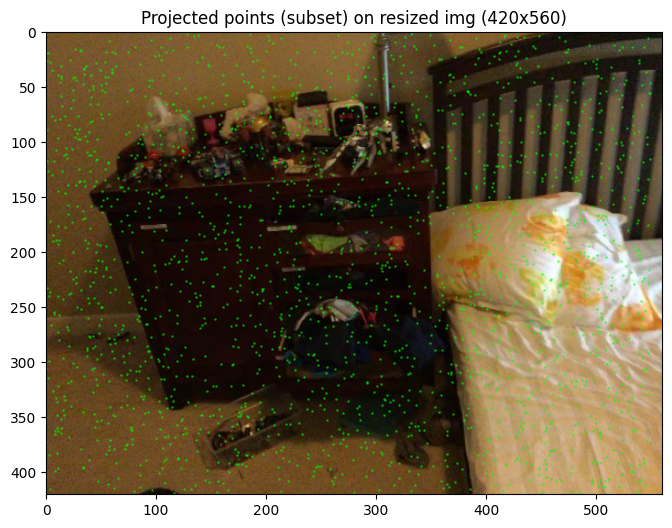

In [17]:
# 5.7 可视化：在图像上画一部分投影点（随机下采样）
num_show = 2000
idx = torch.where(valid)[0]
if idx.numel() > num_show:
    idx = idx[torch.randperm(idx.numel())[:num_show]]

img_vis = img[:3].permute(1,2,0).cpu().numpy()
plt.figure(figsize=(8,6))
plt.imshow(img_vis.astype(np.uint8))
plt.scatter(uv[idx,0].cpu().numpy(), uv[idx,1].cpu().numpy(), s=1, c='lime', alpha=0.4)
plt.title('Projected points (subset) on resized img (420x560)')
plt.xlim([0, W_img])
plt.ylim([H_img, 0])
plt.show()


## 6) DINO 注入命中率（hit-rate）检查
目标：验证“投影采样到了 DINO 特征”是否真的能在 Minkowski 坐标里被 decoder 拿到。

方法：
- 用模型的 `dino` 提取 `(B,1024,30,40)`
- 调用 `model._build_dino_fpn_online(...)` 得到稀疏 FPN（s1..s16）
- 用 **当前 forward 实际使用的坐标**（是否 elastic）构建 SparseTensor，并用 pool 得到 s1..s16 的坐标集合
- 在每个尺度上用 `features_at_coordinates` 查询 DINO FPN，统计非零占比 = hit-rate

对照：分别在 `elastic_p=0` 和 `elastic_p=0.5` 下跑一次，观察 hit-rate 是否显著下降。


In [18]:
# 6.1 构建模型（只用于 DINO forward + 调用内部 build_dino_fpn_online）
model = MODELS.build(cfg.model)
model = model.to(device).eval()
print('Model:', type(model))
print('Has dino:', hasattr(model, 'dino') and model.dino is not None)

import inspect
import oneformer3d.mixformer3d as mixformer3d_mod
print('mixformer3d file:', mixformer3d_mod.__file__)
print('signature _build_dino_fpn_online:', inspect.signature(model._build_dino_fpn_online))


@torch.no_grad()
def compute_hit_rate(cfg_obj: Config, *, batch_size=1):
    ds, dl = build_loader(cfg_obj, batch_size=batch_size, num_workers=0, shuffle=False)
    batch = next(iter(dl))
    data_batch = {'inputs': batch['inputs'], 'data_samples': batch['data_samples']}
    processed = model.data_preprocessor(data_batch, training=False)
    inputs = processed['inputs']
    samples = processed['data_samples']

    points_list = inputs['points']
    imgs = inputs.get('img', None)
    cam_info = inputs.get('cam_info', None)

    assert imgs is not None and cam_info is not None

    # imgs 期望 (B,3,420,560)
    if isinstance(imgs, list):
        imgs = torch.stack([x for x in imgs], dim=0)
    elif torch.is_tensor(imgs) and imgs.dim() == 3:
        imgs = imgs.unsqueeze(0)
    elif torch.is_tensor(imgs) and imgs.dim() == 4:
        pass
    else:
        raise RuntimeError(f"Unexpected imgs type/shape: {type(imgs)} / {getattr(imgs, 'shape', None)}")
    imgs = imgs.to(device)

    feat_maps = model.dino(imgs)

    # cam_info 规范化
    cam_metas = model._normalize_cam_info(cam_info, len(points_list)) if hasattr(model, '_normalize_cam_info') else cam_info

    # 构建 dino_fpn
    dino_fpn = model._build_dino_fpn_online(points_list, feat_maps, cam_metas, samples, elastic_coords=inputs.get('elastic_coords', None))
    print('dino coords source (per-sample):', getattr(model, '_last_dino_coords_source', None))
    assert dino_fpn is not None

    # 构建当前 forward 使用的坐标系（elastic or not）
    voxel_size = float(getattr(model, 'voxel_size', 0.02))
    coords, feats = [], []
    for i in range(len(points_list)):
        pts = points_list[i]
        if 'elastic_coords' in inputs:
            xyz = inputs['elastic_coords'][i] * voxel_size
        else:
            xyz = pts[:, :3]
        feat = pts[:, 3:]
        coords.append(xyz)
        feats.append(feat)

    me_coords, me_feats, *_ = ME.utils.batch_sparse_collate([(c/voxel_size, f) for c,f in zip(coords, feats)], device=device)
    st = ME.SparseTensor(features=me_feats.float(), coordinates=me_coords.int(), device=device)

    # 生成 s1..s16 的坐标集合
    pool = ME.MinkowskiMaxPooling(kernel_size=2, stride=2, dimension=3)
    st_s = [st]
    for _ in range(4):
        st_s.append(pool(st_s[-1]))

    hit_rates = []
    for lvl in range(5):
        coords_q = st_s[lvl].coordinates
        # MinkowskiEngine 的 features_at_coordinates 期望 query_coordinates dtype 与特征 dtype 一致（通常 float32）
        coords_q = coords_q.to(device=dino_fpn[lvl].device, dtype=dino_fpn[lvl].dtype)
        feat_q = dino_fpn[lvl].features_at_coordinates(coords_q)
        hit = (feat_q.abs().sum(dim=1) > 1e-8).float().mean().item()
        hit_rates.append(hit)

    return hit_rates

hit_el0 = compute_hit_rate(cfg_dbg_hit_el0)
hit_el05 = compute_hit_rate(cfg_dbg_hit_el05)
print('hit_rate (elastic=0.0)  s1..s16:', hit_el0)
print('hit_rate (elastic=0.5)  s1..s16:', hit_el05)


2025-12-18 20:54:37,569 - INFO - 从本地 DINOv2 repo 加载: /home/nebula/.cache/torch/hub/facebookresearch_dinov2_main
/home/nebula/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/nebula/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:34: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/nebula/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
2025-12-18 20:54:37,575 - INFO - using MLP layer as FFN
2025-12-18 20:54:40,223 - INFO - ✓ 从本地权重加载: /home/nebula/xxy/dataset/models/dinov2_vitl14_reg4_pretrain.pth
2025-12-18 20:54:40,326 - INFO - ✓ 成功加载 dinov2_vitl14_reg


Model: <class 'oneformer3d.mixformer3d.ScanNet200MixFormer3D'>
Has dino: True
mixformer3d file: /home/nebula/xxy/3D_Reconstruction/oneformer3d/mixformer3d.py
signature _build_dino_fpn_online: (points_list: List[torch.Tensor], feat_maps: torch.Tensor, cam_metas: List[Dict], batch_data_samples: List[Any], elastic_coords: Union[List[Any], NoneType] = None) -> Union[List[MinkowskiSparseTensor.SparseTensor], NoneType]
[LoadCamInfo] 使用固定标准内参: [577.870605, 577.870605, 319.5, 239.5] (ScanNet官方策略)
[Pack3DDetInputs_] keys=['points', 'gt_labels_3d', 'pts_semantic_mask', 'pts_instance_mask', 'sp_pts_mask', 'gt_sp_masks', 'elastic_coords', 'img', 'cam_info'], inputs_keys=['points', 'elastic_coords', 'img', 'cam_info']


/home/nebula/miniconda3/envs/ESAM/lib/python3.8/site-packages/mmdet3d/structures/points/base_points.py:136: UserWarning: point got color value beyond [0, 255]
  warnings.warn('point got color value beyond [0, 255]')


dino coords source (per-sample): ['elastic']
[LoadCamInfo] 使用固定标准内参: [577.870605, 577.870605, 319.5, 239.5] (ScanNet官方策略)
[Pack3DDetInputs_] keys=['points', 'gt_labels_3d', 'pts_semantic_mask', 'pts_instance_mask', 'sp_pts_mask', 'gt_sp_masks', 'elastic_coords', 'img', 'cam_info'], inputs_keys=['points', 'elastic_coords', 'img', 'cam_info']
dino coords source (per-sample): ['elastic']
hit_rate (elastic=0.0)  s1..s16: [1.0, 0.9999999403953552, 1.0, 0.9999999403953552, 1.0]
hit_rate (elastic=0.5)  s1..s16: [0.9999999403953552, 0.9999999403953552, 1.0, 1.0, 1.0]


In [ ]:
# 6.2 Batch>1 cam_info split sanity
# 目标：覆盖 notebook 单样本无法覆盖的风险点：
# - batch>1 时 cam_info 是否被正确拆分（每个 sample 一个 dict）
# - img 是否是 (B,3,420,560) 且与 cam_info 一一对应
# - 每个 sample 的 3D->2D 投影是否合理（valid_rate）

ds_b, dl_b = build_loader(cfg_dbg_hit_el05, batch_size=4, num_workers=2, shuffle=False)
b = next(iter(dl_b))

with torch.no_grad():
    processed = model.data_preprocessor({'inputs': b['inputs'], 'data_samples': b['data_samples']}, training=False)

inp = processed['inputs']
samples = processed['data_samples']

pts_list = inp['points']
imgs = inp.get('img', None)
cam_raw = inp.get('cam_info', None)
B = len(pts_list)

print('[batch] B=', B)
print('[batch] points shapes:', [tuple(p.shape) for p in pts_list])
print('[batch] img type:', type(imgs), 'shape:', getattr(imgs, 'shape', None))
print('[batch] cam_info type:', type(cam_raw))

cam_metas = model._normalize_cam_info(cam_raw, B)
print('[batch] normalized cam_metas len:', len(cam_metas))

for i in range(B):
    meta_i = cam_metas[i]
    img_meta_i = getattr(samples[i], 'img_metas', None)
    if not isinstance(img_meta_i, dict):
        img_meta_i = samples[i].metainfo if hasattr(samples[i], 'metainfo') else {}

    fx, fy, cx, cy = [float(x) for x in meta_i['intrinsics']]
    H_img_i, W_img_i = meta_i.get('img_size_dino', (420, 560))
    pts_i = pts_list[i][:1000].float()

    # 额外对照：不做 reverse（直接用增强后的 xyz_train 当 world）
    xyz_world_raw = pts_i[:, :3].clone()


    xyz_world = torch.as_tensor(
        apply_3d_transformation(pts_i[:, :3].clone(), coord_type='DEPTH', img_meta=img_meta_i, reverse=True),
        dtype=torch.float32
    )

    pose = meta_i.get('pose', meta_i.get('extrinsics', None))
    T_c2w = torch.as_tensor(pose, dtype=torch.float32)
    if T_c2w.dim() > 2:
        T_c2w = T_c2w.reshape(-1, 4, 4)[0]
    # 确保所有张量在同一 device（data_preprocessor 可能已将 points 放到 GPU）
    dev = xyz_world.device
    T_c2w = T_c2w.to(device=dev)
    T_w2c = torch.linalg.inv(T_c2w)
    xyz_h = torch.cat([
        xyz_world,
        torch.ones((xyz_world.shape[0], 1), dtype=torch.float32, device=dev)
    ], dim=1)
    xyz_cam = (xyz_h @ T_w2c.transpose(0, 1))[:, :3]

    xyz_h_raw = torch.cat([
        xyz_world_raw.to(dev),
        torch.ones((xyz_world_raw.shape[0], 1), dtype=torch.float32, device=dev)
    ], dim=1)
    xyz_cam_raw = (xyz_h_raw @ T_w2c.transpose(0, 1))[:, :3]

    uv_raw, valid_raw = project_points_to_uv(
        xyz_cam, feat_hw=(int(H_img_i), int(W_img_i)),
        max_depth=float(meta_i.get('max_depth', 20.0)),
        standard_intrinsics=(fx, fy, cx, cy),
        already_scaled=True,
    )

    uv, valid = project_points_to_uv(
        xyz_cam, feat_hw=(int(H_img_i), int(W_img_i)),
        max_depth=float(meta_i.get('max_depth', 20.0)),
        standard_intrinsics=(fx, fy, cx, cy),
        already_scaled=True,
    )

    if bool(img_meta_i.get('img_flip', img_meta_i.get('flip', False))):
        uv = uv.clone()
        uv[:, 0] = float(W_img_i - 1) - uv[:, 0]
        uv_raw = uv_raw.clone()
        uv_raw[:, 0] = float(W_img_i - 1) - uv_raw[:, 0]

    print(f'[batch][{i}] img_size_dino={(int(H_img_i), int(W_img_i))}, flip={bool(img_meta_i.get("flip", False))}, pcd_hflip={bool(img_meta_i.get("pcd_horizontal_flip", False))}, pcd_vflip={bool(img_meta_i.get("pcd_vertical_flip", False))}, flow={img_meta_i.get("transformation_3d_flow", None)}, valid_rate_raw={float(valid_raw.float().mean().item()):.4f}, valid_rate_rev={float(valid.float().mean().item()):.4f}')

print('[batch] done')

In [ ]:
# 6.2b Dump raw cam_info structure (before _normalize_cam_info)
# 用于确认 default_collate 后 cam_info 的真实形态，避免任何假设。

cam_raw = inp.get('cam_info', None)
print('[cam_raw] type:', type(cam_raw))
if isinstance(cam_raw, list):
    print('  list_len=', len(cam_raw))
    if len(cam_raw) > 0:
        print('  head_type=', type(cam_raw[0]))
        if isinstance(cam_raw[0], dict):
            for k, v in cam_raw[0].items():
                if torch.is_tensor(v):
                    print(f'    {k}: Tensor shape={tuple(v.shape)} dtype={v.dtype} device={v.device}')
                else:
                    print(f'    {k}: {type(v)} len={len(v) if isinstance(v,(list,tuple)) else "-"} value_head={v[0] if isinstance(v,(list,tuple)) and len(v)>0 else v}')
elif isinstance(cam_raw, dict):
    for k, v in cam_raw.items():
        if torch.is_tensor(v):
            print(f'  {k}: Tensor shape={tuple(v.shape)} dtype={v.dtype} device={v.device}')
        else:
            print(f'  {k}: {type(v)} len={len(v) if isinstance(v,(list,tuple)) else "-"} value_head={v[0] if isinstance(v,(list,tuple)) and len(v)>0 else v}')
else:
    print('  cam_raw=', cam_raw)


## 7) 结论解释建议
- 若 RGB 一致性误差整体很大（且呈系统性偏移/镜像）：说明投影链路仍有错（flip/resize/pose/坐标系）。
- 若 RGB 一致性很好，但 hit-rate 在 elastic=0.5 显著下降：说明 DINO 注入坐标系与 backbone 坐标系不一致（典型是 elastic/量化/stride 失配），模型会学会忽略 DINO。
- 若 RGB 一致性很好，hit-rate 也高，但仍无提升：才更像“任务/架构已饱和或 DINO 融合方式需调整”。
